# Import Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


# Data Preprocessing

In [124]:
# Load the dataset to pandas Data Frame
sms = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin1')

In [125]:
df=pd.DataFrame(sms)

In [126]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [127]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']

In [128]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [129]:
# Replace the null values with a null string
mail_data = df.where((pd.notnull(df)), '')

In [130]:
mail_data.shape

(5572, 2)

In [131]:
mail_data = mail_data.iloc[:,[0,1]]
mail_data.columns = ["label", "message"]
mail_data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [132]:
mail_data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

# Data Visualization

In [133]:
mail_data['length'] = mail_data['message'].apply(len)
mail_data.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


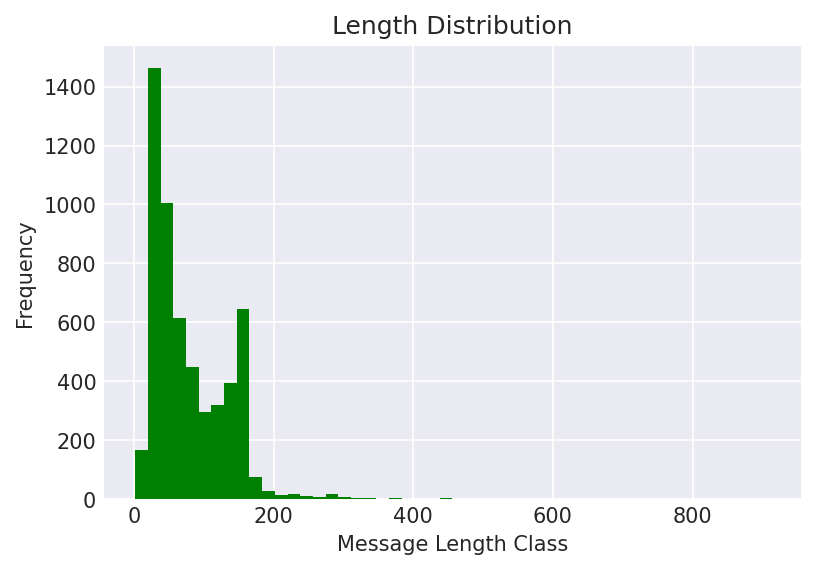

In [134]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(dpi = 150)
ax = plt.axes()
mail_data['length'].plot(bins=50, kind='hist',ax=ax,color = 'green')
ax.set(xlabel = 'Message Length Class',ylabel = 'Frequency',title = 'Length Distribution');


In [135]:
mail_data.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [136]:
mail_data[mail_data['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

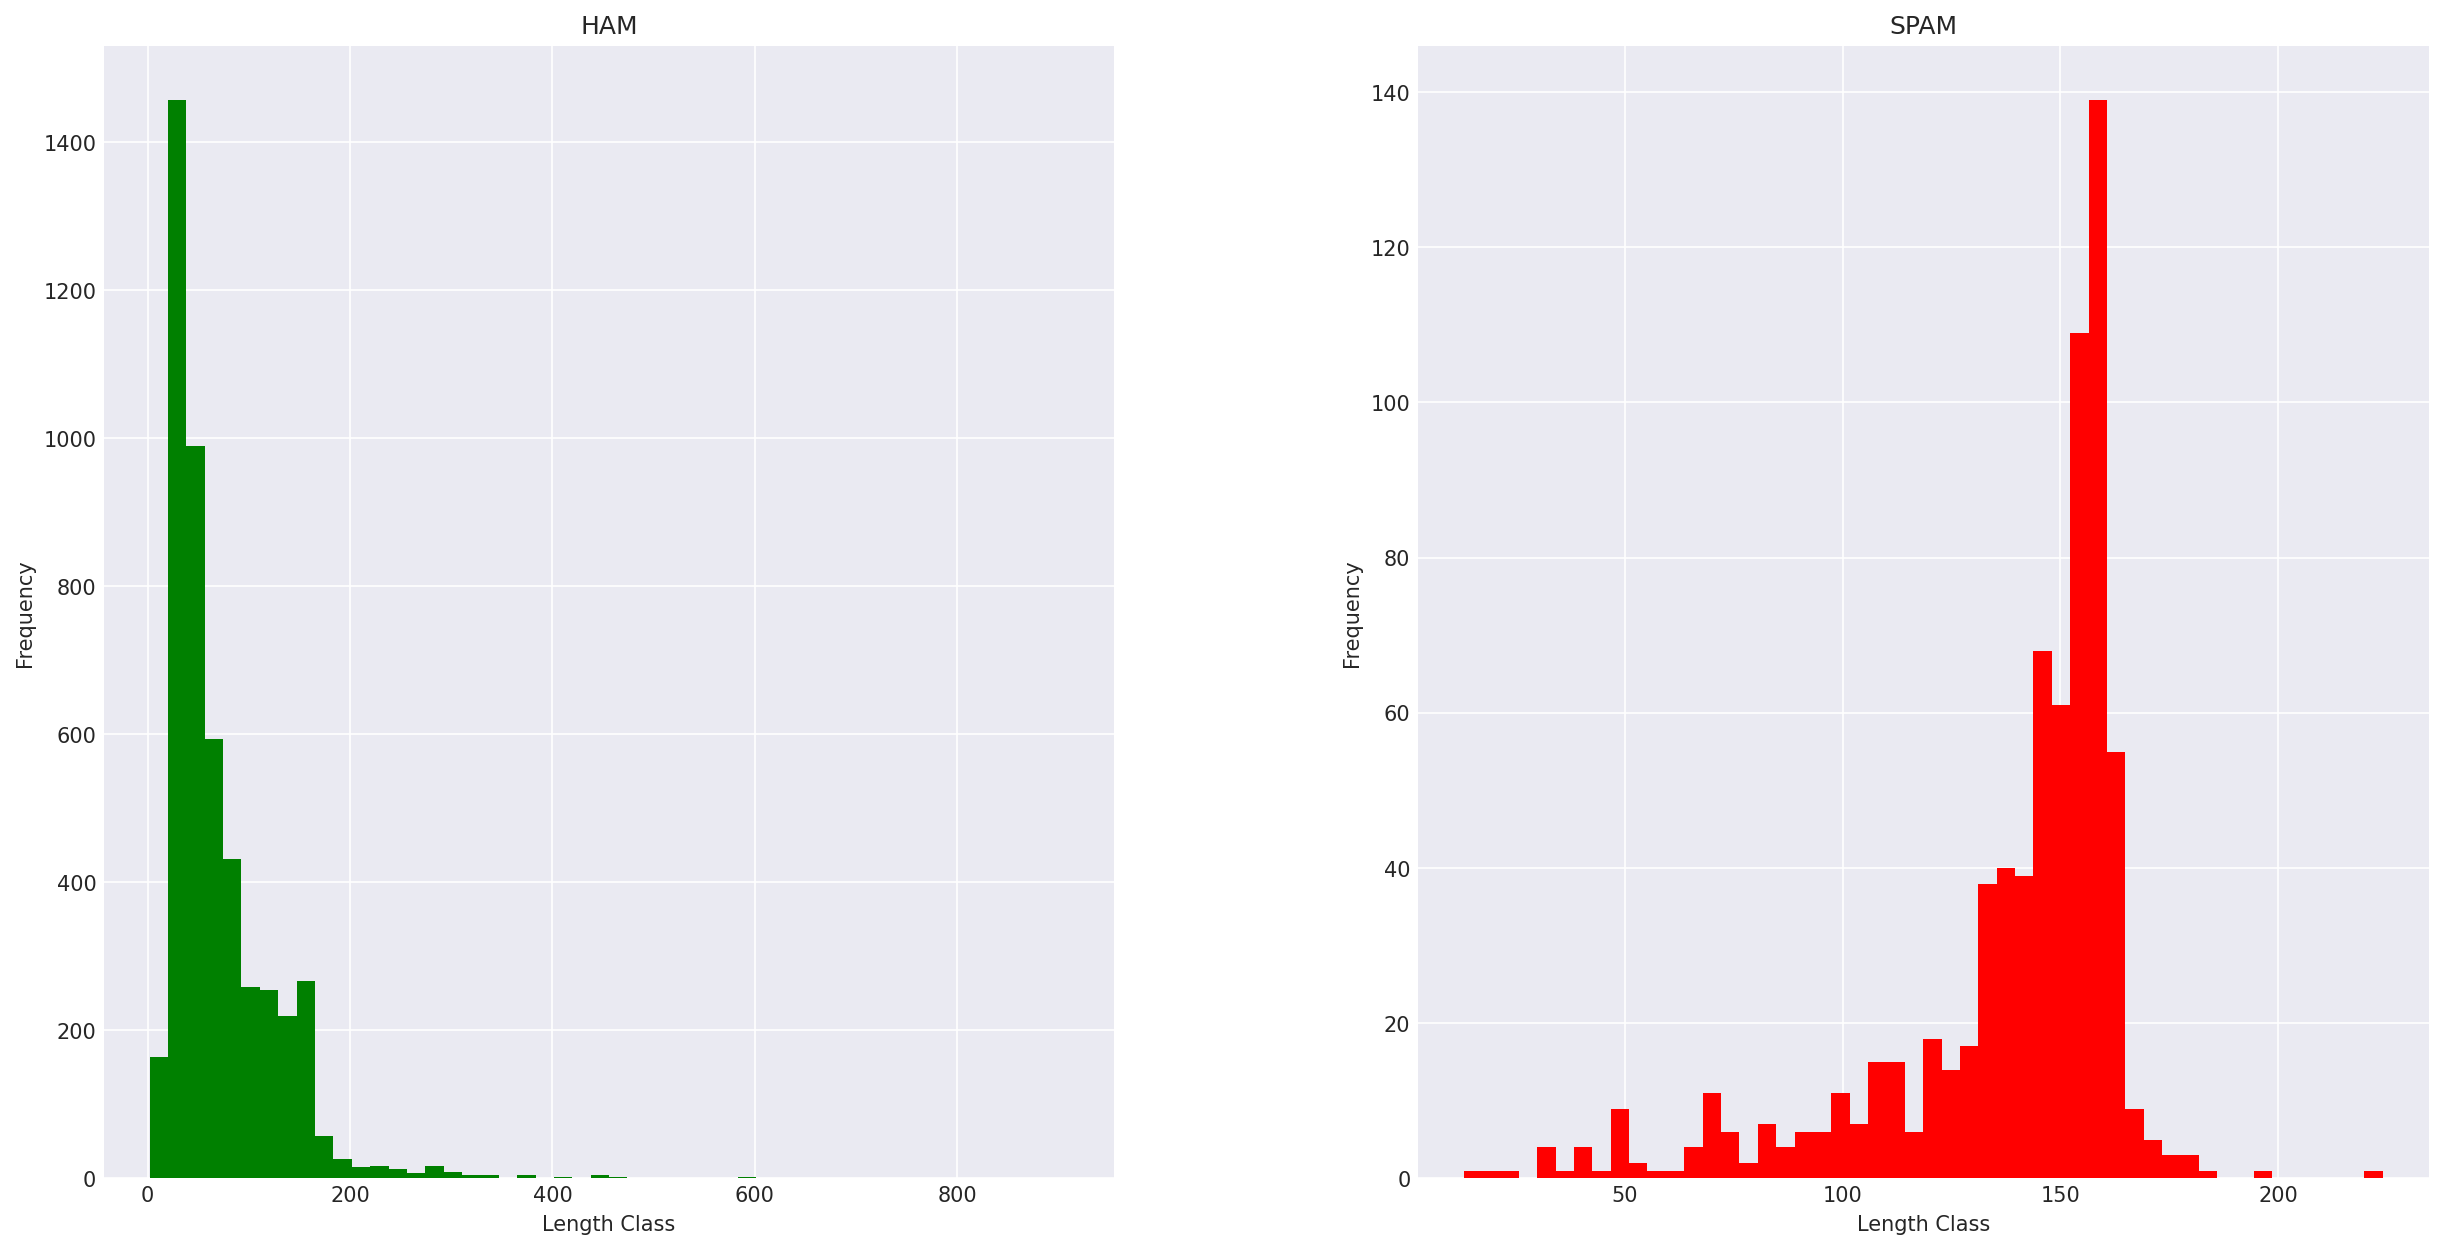

In [137]:
fig,ax = plt.subplots(1,2,figsize=(20,10),dpi = 150)

mail_data[mail_data['label']=='ham'].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'HAM')
mail_data[mail_data['label']=='spam'].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM');

# Labelling

In [138]:
# Label spam mail as 0
# Label ham mail as 1
mail_data.loc[mail_data['label']=='spam', 'label',] = 0
mail_data.loc[mail_data['label']=='ham', 'label',] = 1

In [139]:
mail_data.head()

,label,message,length
0,1,"Go until jurong point, crazy.. Available only ...",111
1,1,Ok lar... Joking wif u oni...,29
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,1,U dun say so early hor... U c already then say...,49
4,1,"Nah I don't think he goes to usf, he lives aro...",61


In [140]:
# Separate data X--> text, Y--> label
X = mail_data['message']
Y = mail_data['label']

In [141]:
print(X)
print('.........................................................')
print(Y)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: message, Length: 5572, dtype: object
.........................................................
0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: label, Length: 5572, dtype: object


# Data Split

In [142]:
# Split the data into train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state = 3)

# Feature Extraction

In [143]:
# Transform the text data to feature vectors that can be used as input to the svm model using TfidfVectorizer
# Convert the text to lower case letters
feature_extraction = TfidfVectorizer(min_df=1, stop_words = 'english', lowercase = 'True')
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

# Convert Y-train and Y_test values as integers
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')


# Training the model with SVM

In [144]:
# Training SVM with training data
model = LinearSVC()
model.fit(X_train_features, Y_train)

LinearSVC()

# Evaluation of the model

In [145]:
# Prediction on train data
prediction_on_training_data = model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)
print('Accuracy on train data: ', accuracy_on_training_data)

# Prediction on test data
prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)
print('Accuracy on test data: ', accuracy_on_test_data)

Accuracy on train data:  0.9995512676688355
Accuracy on test data:  0.9856502242152466


# Prediction on new mail

In [146]:
input_mail = ["Reply with your name and address and YOU WILL RECEIVE BY POST a weeks completely free accommodation."]
# Convert text to feature vectors
input_mail_features = feature_extraction.transform(input_mail)

# Making prediction
prediction = model.predict(input_mail_features)
print(prediction)

if(prediction[0] == 1):
    print('HAM MAIL')
else:
    print('SPAM MAIL')

[0]
SPAM MAIL


In [147]:
input_mail = ["Yeah, probably but not sure. Ilol let u know, but personally I wuldnt bother."]
# Convert text to feature vectors
input_mail_features = feature_extraction.transform(input_mail)

# Making prediction
prediction = model.predict(input_mail_features)
print(prediction)

if(prediction[0] == 1):
    print('HAM MAIL')
else:
    print('SPAM MAIL')

[1]
HAM MAIL
